<a href="https://colab.research.google.com/github/svenroed/notebooks/blob/master/Episode_15_RL_Trading_Env/tf_trade_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tf-agents

     |████████████████████████████████| 1.2MB 7.6MB/s 


In [16]:
pip install pyvirtualdisplay

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np
import pandas as pd

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts

tf.random.set_seed(12)
tf.config.list_physical_devices('GPU') 

[]

In [18]:
def mprint(_s, verbose = 1):
    if(verbose == 1):
        print(_s)

verbose = 0

In [19]:
np.random.choice([0,1])

1

In [20]:
class MyTradeEnv(py_environment.PyEnvironment):

    def __update_state(self):
        _idx = self._dayIndex + self._currentDayIndex
        _x = self._normPriceArray[:_idx]
        self._state = np.append(np.pad(_x, (0,self._maxDayIndex - _idx)), self._activePosition)

    def __select_episode(self):
        #r = np.random.choice([0,1])
        if(self.price_nr == 0):
            self.price_nr = 1
        else:
            self.price_nr = 0

        pa = self.price_data[self.price_nr]

        na = (pa-min(pa))/(max(pa)-min(pa))

        return pa, na


    def __init__(self):
        #2 Actions: We have 3 actions. Action 0: skip, Action 1: buy, Action 2: sell, Action 3: close open position
        self._action_spec = array_spec.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')

        #representation of the enviroment: price + open position state
        self._observation_spec = array_spec.BoundedArraySpec(
            shape=(22,), dtype=np.float32, minimum=0, name='observation')


        #define price data
        self.price_data = np.float32(np.array([
                [10, 11, 12, 11, 12, 13, 14, 13, 12, 11, 12, 11, 10, 9, 10, 11, 12, 11, 12, 13],
                [10, 11, 12, 13, 14, 15, 14, 15, 16, 15, 16, 15, 16, 17, 16, 17, 16,15, 16, 15]
            ]))

        self.price_nr = 0
        
        self._episode_ended = False

        self._position = 0      # 0 - no position, 1 - long, -1 - short
        self._fees = -0.5       # broker fees
        self._spread = 0.02     # spread
        self._shares = 100      # number of trading shares
        self._money = 10000.0   # money
        self._pnl = 0.0         # PnL


        self._dayIndex = 10       # days of history are available from the beginning
        self._maxDayIndex = 20    # maximun days of trading investment
        self._currentDayIndex = 0 # current day idex -> starts with 0

        # example of enviroment observation -> price list
        #self._priceArray = np.float32(np.array([10, 11, 12, 11, 12, 13, 14, 13, 12, 11, 12, 11, 10, 9, 10, 11, 12, 11, 12, 13]))
        #self._priceArray = np.float32(np.array([10, 9, 10, 11, 12, 13, 14, 13, 12, 13, 12, 11, 10,  9, 10,  9,  8, 7,  8,  7]))
        
        # normalized price -> just for the testing
        #self._normPriceArray = (self._priceArray-min(self._priceArray))/(max(self._priceArray)-min(self._priceArray))
        #self._normPriceArray =self._priceArray
        self._priceArray, self._normPriceArray = self.__select_episode()

        # active position -> onehot encoded -> index 0 = 1 - open long position, index 1 = 1 - open short position
        self._activePosition = np.array([0,0])

        #calculate new observation state
        #every new step (new day) we are adding new price
        self.__update_state()
       
    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._episode_ended = False
        self._currentDayIndex = 0
        self._pnl = 0

        self._priceArray, self._normPriceArray = self.__select_episode()
        self.__reset_position()
        self.__update_state()

        return ts.restart(np.array(self._state, dtype=np.float32))

    def __open_position(self, pos, action, idx):
        
        reward = 0
        actionPnl = 0

        if(self._position == 0): #no open positions

            self._position = pos # set position direction
            #update the position data
            if(pos == 1):
                self._activePosition[0] = 1.0
            elif(pos == -1):
                self._activePosition[1] = 1.0

            needMoney = self._shares * self._priceArray[idx-1] #calculate how much we need to pay

            if(needMoney > self._money): #no more money to trade => exit
                self._episode_ended = True # fnish the episode 
                reward = -100  
                print('ERROR NO MONEY!')
            else:  #open new position
                actionPnl = self._fees - self._spread*self._shares # calculate immidiade pnl
                mprint('OPEN LONG -> actionPnl = {}, price = {}'.format(actionPnl,  self._state[idx-1]), verbose=verbose)
                #reward = 0
                reward = actionPnl #set reward equal pnl for current day

        else: # position is already open
            action = 0 #set action to skip
            mprint('OPEN LONG -> Position Open -> go to Skip', verbose=verbose)


        return reward, actionPnl, action
    

    def __reset_position(self):
        self._position = 0
        self._activePosition = np.array([0,0])


    def __calculate_price_change(self, i1, i2):
        return (np.abs(self._priceArray[i1]) - np.abs(self._priceArray[i2]))*self._position

    def __calculate_close_position_pnl(self, diffPrice):
        return diffPrice * self._shares + self._fees - self._spread*self._shares

    def _step(self, action):

        if self._episode_ended:
            # The last action ended the episode. Ignore the current action and start
            # a new episode.
            return self.reset()

        reward = 0
        actionPnl = 0

        #go to the next day
        self._currentDayIndex += 1

        # calculate new index, because we can't buy or sell with the visible price
        # action selected on visible history, par performs on the next observation
        _idx = self._dayIndex + self._currentDayIndex
        mprint('action = {} _idx = {}'.format(action,  _idx), verbose=verbose)
        
        #add new price for observation
        self._state = np.pad(self._normPriceArray[:_idx], (0,self._maxDayIndex - _idx))

        #select the action
        if(1 == action): #buy
            reward, actionPnl, action = self.__open_position(1, action, _idx)

        elif(2 == action): #sell
            reward, actionPnl, action = self.__open_position(-1, action, _idx)


        elif(3 == action): #close
            if(self._position != 0):

                #calculate the pirce change
                diffPrice = self.__calculate_price_change(_idx-1, _idx-2)
                actionPnl = self.__calculate_close_position_pnl(diffPrice)
                mprint('CLOSE -> actionPnl = {}, price = {}'.format(actionPnl,  self._state[_idx-1]), verbose=verbose)

                self.__reset_position()

                reward = actionPnl #set reward equeal to daychange pnl

            else:
                action = 0 # nothing to close -> go to skip action


        if(0 == action): #skip action 
            if(self._position != 0): #position is open
                diffPrice = self.__calculate_price_change(_idx-1, _idx-2)
                actionPnl = diffPrice * self._shares
                mprint('SKIP -> actionPnl = {}, price = {}'.format(actionPnl,  self._state[_idx-1]), verbose=verbose)
                
                #reward = 0
                reward = actionPnl
            else:
                mprint('SKIP -> ...no position', verbose=verbose)
                reward = -10 # if no position set negative reward to stimulate agent


        if _idx == self._maxDayIndex: #if we have a last observation day
            self._episode_ended = True


        if self._episode_ended == True:
            if(self._position != 0):
                diffPrice = self.__calculate_price_change(_idx-1, _idx-2)
                actionPnl = self.__calculate_close_position_pnl(diffPrice)

                self.__reset_position()



        self._pnl += actionPnl # update PnL

        self._state = np.append(self._state, self._activePosition) # add position state to the observation state

        mprint('PnL = {}'.format(self._pnl), verbose=verbose)
        mprint('{}'.format(self._state), verbose=verbose)

        #print('-->reward', reward)
        if self._episode_ended:
            reward = self._pnl
            return ts.termination(np.array(self._state, dtype=np.float32), reward)
        else:
            return ts.transition(
                np.array(self._state, dtype=np.float32), reward=reward, discount=1.0)

In [21]:
environment = MyTradeEnv()
utils.validate_py_environment(environment, episodes=1)

In [22]:
print('action_spec:', environment.action_spec())
print('time_step_spec.observation:', environment.time_step_spec().observation)
print('time_step_spec.step_type:', environment.time_step_spec().step_type)
print('time_step_spec.discount:', environment.time_step_spec().discount)
print('time_step_spec.reward:', environment.time_step_spec().reward)

action_spec: BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=3)
time_step_spec.observation: BoundedArraySpec(shape=(22,), dtype=dtype('float32'), name='observation', minimum=0.0, maximum=3.4028234663852886e+38)
time_step_spec.step_type: ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')
time_step_spec.discount: BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0)
time_step_spec.reward: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [23]:
# get_new_action = np.array(1, dtype=np.int32)
# end_round_action = np.array(3, dtype=np.int32)

# environment = MyTradeEnv()
# time_step = environment.reset()
# print('RESET')
# print(time_step)
# time_step = environment.current_time_step()
# print('current_time_step')
# print(time_step)
# time_step = environment.step(get_new_action)
# print('action')
# print(time_step)



In [24]:
get_new_action = np.array(1, dtype=np.int32)
end_round_action = np.array(3, dtype=np.int32)

environment = MyTradeEnv()
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward
print('cumulative_reward', cumulative_reward)
print('-------------')
#print(time_step.observation)


for _ in range(4):
  time_step = environment.step(get_new_action)
  print(time_step)
  #print(time_step.observation)
  cumulative_reward += time_step.reward
  print('cumulative_reward', cumulative_reward)

print('-----------------')
time_step = environment.step(end_round_action)
print(time_step)
cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward)

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([0.2, 0.4, 0.6, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32))
cumulative_reward 0.0
-------------
TimeStep(step_type=array(1, dtype=int32), reward=array(-2.5, dtype=float32), discount=array(1., dtype=float32), observation=array([0.2, 0.4, 0.6, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.6, 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ], dtype=float32))
cumulative_reward -2.5
TimeStep(step_type=array(1, dtype=int32), reward=array(-100., dtype=float32), discount=array(1., dtype=float32), observation=array([0.2, 0.4, 0.6, 0.4, 0.6, 0.8, 1. , 0.8, 0.6, 0.4, 0.6, 0.4, 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. ], dtype=float32))
cumulative_reward -102.5
TimeStep(step_type=array(1, dtype=int32), reward=array(-100., dtype=float32), discount=array(1., dtype=float32), observati

In [25]:
def Randwalk(n):

   x = 0
   y = 10

   time = [x]
   position = [y] 

   for i in range (1,n):
       move = np.random.uniform(0,1)

       if move < 0.5:    
           x += 1
           y += 1  

       if move > 0.5:    
           x += 1
           y += -1
 
       time.append(x)
       position.append(y)

   return position

In [26]:
#k = Randwalk(20)
#pd.Series(k).plot()

In [27]:
tf_env = tf_py_environment.TFPyEnvironment(environment)

print(isinstance(tf_env, tf_environment.TFEnvironment))
print('...................')
print("TimeStep Specs:", tf_env.time_step_spec())
print('...................')
print("Action Specs:", tf_env.action_spec())

True
...................
TimeStep Specs: TimeStep(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)), observation=BoundedTensorSpec(shape=(22,), dtype=tf.float32, name='observation', minimum=array(0., dtype=float32), maximum=array(3.4028235e+38, dtype=float32)))
...................
Action Specs: BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32))


In [28]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
tf.compat.v1.enable_v2_behavior()

In [29]:
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 2  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 500  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 5000  # @param {type:"integer"}

In [30]:
train_env = tf_py_environment.TFPyEnvironment(MyTradeEnv())
eval_env = tf_py_environment.TFPyEnvironment(MyTradeEnv())

In [31]:
fc_layer_params = (40,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [32]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [33]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [34]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [35]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

In [36]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

310.25

In [37]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [38]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(22,), dtype=tf.float32, name='observation', minimum=array(0., dtype=float32), maximum=array(3.4028235e+38, dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [39]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [40]:
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  #print(time_step)
  action_step = policy.action(time_step)
  #print(action_step.action.numpy())
  next_time_step = environment.step(action_step.action)
  #print(next_time_step)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=1)

In [41]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 22), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.float32, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [42]:
iterator = iter(dataset)

print(iterator)

In [44]:

try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(10000):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
step = 500: loss = 3806.747314453125
step = 1000: loss = 4836.974609375
step = 1500: loss = 6014.40625
step = 2000: loss = 3407.41162109375
step = 2500: loss = 3519.95751953125
step = 3000: loss = 5833.23388671875
step = 3500: loss = 2673.3427734375
step = 4000: loss = 3531.75244140625
step = 4500: loss = 2720.333984375
step = 5000: loss = 4688.12548828125
step = 5000: Average Return = 21.25
step = 5500: loss = 3609.40869140625
step = 6000: loss = 1936.036376953125
step = 6500: loss = 3770.70556640625
step = 7000: loss = 2485.005126953125
step = 7500: loss = 2018.025390625
step = 8000: loss = 3917.2939453125
step = 8500: loss = 1832.094970703125
step = 9000: loss = 2301.56298828125
step = 9500: loss = 2318.47607421875
step = 10000: loss = 3450.5224609375
step = 10000: Average Return = 211.25


ValueError: ignored

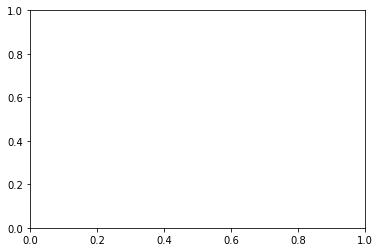

In [45]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')


In [46]:
verbose = 1
time_step = eval_env.reset()

cumulative_reward = time_step.reward.numpy()
print('cumulative_reward', cumulative_reward)
while not time_step.is_last():
    action_step = agent.policy.action(time_step)
    #print('action', action_step.action.numpy())
    time_step = eval_env.step(action_step.action)
    cumulative_reward += time_step.reward.numpy()
    #print('observ',time_step.observation.numpy())
    print('cumulative_reward', cumulative_reward)
print('final_reward', time_step.reward.numpy())
verbose = 0    


cumulative_reward [0.]
action = 3 _idx = 11
SKIP -> ...no position
PnL = 0
[0.2        0.40000001 0.60000002 0.40000001 0.60000002 0.80000001
 1.         0.80000001 0.60000002 0.40000001 0.60000002 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
cumulative_reward [-10.]
action = 3 _idx = 12
SKIP -> ...no position
PnL = 0
[0.2        0.40000001 0.60000002 0.40000001 0.60000002 0.80000001
 1.         0.80000001 0.60000002 0.40000001 0.60000002 0.40000001
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
cumulative_reward [-20.]
action = 1 _idx = 13
OPEN LONG -> actionPnl = -2.5, price = 0.20000000298023224
PnL = -2.5
[0.2        0.40000001 0.60000002 0.40000001 0.60000002 0.80000001
 1.         0.80000001 0.60000002 0.40000001 0.60000002 0.40000001
 0.2        0.         0.         0.         0.         0.
 0.         0.         1.         0.        ]
cumulative_reward [-22.

In [47]:
actions -> 2231131313

actions -> 2311111222
actions -> 3113133320

SyntaxError: ignored

In [48]:
#after 20000 steps
final_reward [-210.]
final_reward [95.]

#after 100000 steps
final_reward [390.]
final_reward [385.]

NameError: ignored

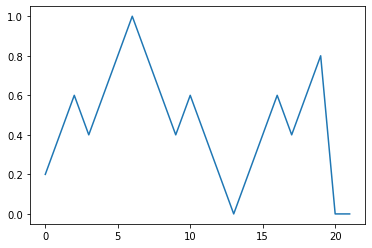

In [49]:
pd.Series(time_step.observation.numpy().flatten()).plot()

In [50]:
tf.config.list_physical_devices('GPU')

[]

In [51]:
pa = np.float32(np.array([
    [10, 11, 12, 11, 12, 13, 14, 13, 12, 11, 12, 11, 10, 9, 10, 11, 12, 11, 12, 13],
    [10, 11, 12, 13, 14, 15, 14, 15, 16, 15, 16, 15, 16, 17, 16, 17, 16,15, 16, 15]
    ]))
    

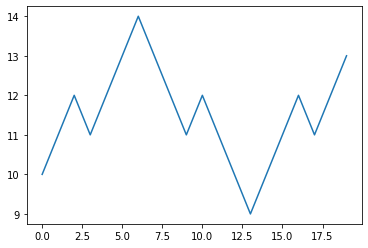

In [52]:
pd.Series(pa[0]).plot()
#pd.Series(pa[1]).plot()

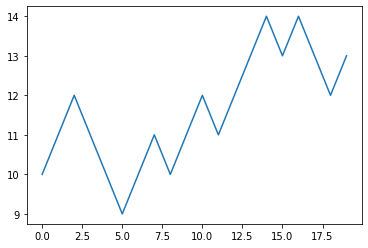

In [53]:
k = Randwalk(20)
pd.Series(k).plot()

In [54]:
np.array(k)

array([10, 11, 12, 11, 10,  9, 10, 11, 10, 11, 12, 11, 12, 13, 14, 13, 14,
       13, 12, 13])